[11:06:16] INFO: Checking if file exists: /Users/sriujjwalreddyb/TBD/data/OLA-well1-4-Image Export-06_c1.jpg
[11:06:16] INFO: Reading image with OpenCV
[11:06:16] DEBUG: Original image shape: (2016, 2016, 3), dtype: uint8
[11:06:16] INFO: Converting to grayscale
[11:06:16] DEBUG: Gray image shape: (2016, 2016), dtype: uint8


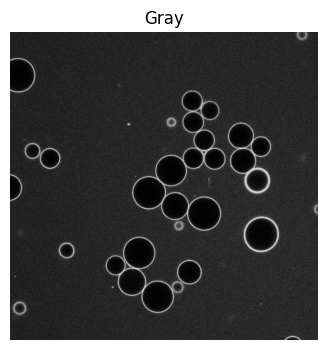

[11:06:16] INFO: Blurring for noise reduction
[11:06:16] INFO: Applying unsharp mask


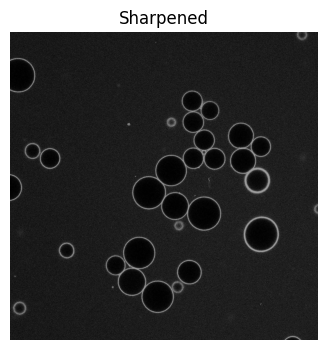

[11:06:16] INFO: Applying adaptive threshold


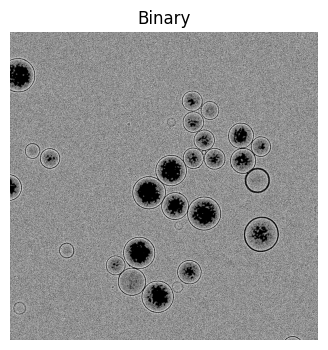

[11:06:16] INFO: Closing small gaps (morphology)


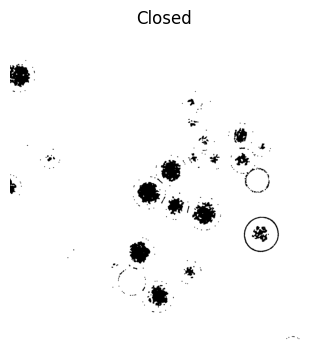

[11:06:17] INFO: Finding contours
[11:06:17] DEBUG: Total contours found: 16
[11:06:17] INFO: Filtering contours by circularity and drawing
[11:06:17] INFO: Detected 0 vesicle rings


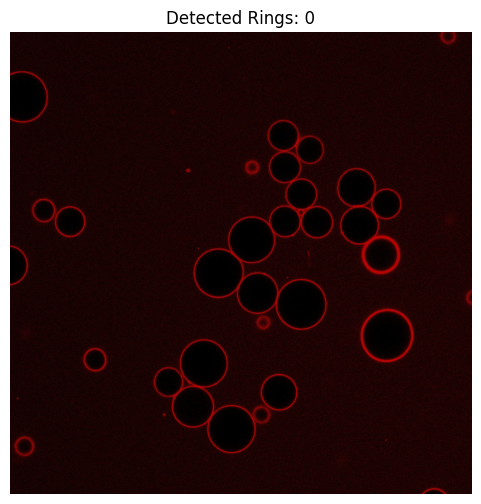

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

# ─── 0. Configure logging ───────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.DEBUG,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)

# ─── 1. Load image ─────────────────────────────────────────────────────────────
image_path = '/Users/sriujjwalreddyb/TBD/data/OLA-well1-4-Image Export-06_c1.jpg'
logging.info(f"Checking if file exists: {image_path}")
if not os.path.exists(image_path):
    logging.error("File not found.")
    raise FileNotFoundError(f"Image file not found: {image_path}")

logging.info("Reading image with OpenCV")
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
if img is None:
    logging.error("cv2.imread returned None")
    raise ValueError("Failed to load image—check path and permissions")

logging.debug(f"Original image shape: {img.shape}, dtype: {img.dtype}")
cv2.imwrite("debug_01_original.jpg", img)

# ─── 2. Convert to grayscale ──────────────────────────────────────────────────
logging.info("Converting to grayscale")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
logging.debug(f"Gray image shape: {gray.shape}, dtype: {gray.dtype}")
cv2.imwrite("debug_02_gray.jpg", gray)

# Optionally display
plt.figure(figsize=(4,4))
plt.imshow(gray, cmap='gray')
plt.title("Gray")
plt.axis('off')
plt.show()

# ─── 3. Denoise & sharpen ─────────────────────────────────────────────────────
logging.info("Blurring for noise reduction")
blurred = cv2.GaussianBlur(gray, (5, 5), 1)
cv2.imwrite("debug_03_blurred.jpg", blurred)

logging.info("Applying unsharp mask")
sharpened = cv2.addWeighted(gray, 1.8, blurred, -0.8, 0)
cv2.imwrite("debug_04_sharpened.jpg", sharpened)

plt.figure(figsize=(4,4))
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened")
plt.axis('off')
plt.show()

# ─── 4. Adaptive threshold ────────────────────────────────────────────────────
logging.info("Applying adaptive threshold")
binary = cv2.adaptiveThreshold(
    sharpened, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)
cv2.imwrite("debug_05_binary.jpg", binary)

plt.figure(figsize=(4,4))
plt.imshow(binary, cmap='gray')
plt.title("Binary")
plt.axis('off')
plt.show()

# ─── 5. Morphological close ──────────────────────────────────────────────────
logging.info("Closing small gaps (morphology)")
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
cv2.imwrite("debug_06_closed.jpg", closed)

plt.figure(figsize=(4,4))
plt.imshow(closed, cmap='gray')
plt.title("Closed")
plt.axis('off')
plt.show()

# ─── 6. Contour detection ─────────────────────────────────────────────────────
logging.info("Finding contours")
contours, _ = cv2.findContours(
    closed,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)
logging.debug(f"Total contours found: {len(contours)}")

# ─── 7. Filter for circles & draw ─────────────────────────────────────────────
logging.info("Filtering contours by circularity and drawing")
output = img.copy()
diameters = []
circle_count = 0

for i, cnt in enumerate(contours, start=1):
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0 or area < 100:
        continue

    circ = 4 * np.pi * area / (perimeter * perimeter)
    if circ > 0.6:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        if 10 <= radius <= 90:
            center = (int(x), int(y))
            r = int(radius)
            cv2.circle(output, center, r, (0, 255, 0), 2)
            diameters.append(r * 2)
            circle_count += 1
            logging.debug(f"  • Contour #{i}: area={area:.1f}, circ={circ:.2f}, radius={r}")

logging.info(f"Detected {circle_count} vesicle rings")
cv2.imwrite("debug_07_output.jpg", output)

# ─── 8. Final visualization & stats ───────────────────────────────────────────
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(output_rgb)
plt.title(f"Detected Rings: {circle_count}")
plt.axis('off')
plt.show()

# Histogram of diameters
if diameters:
    plt.figure(figsize=(6,4))
    plt.hist(diameters, bins=10, edgecolor='black')
    plt.xlabel('Diameter (pixels)')
    plt.ylabel('Count')
    plt.title('Diameter Distribution')
    plt.show()

    logging.info(f"Mean diameter: {np.mean(diameters):.2f}px")
    logging.info(f"Std deviation: {np.std(diameters):.2f}px")

# ────────────────────────────────────────────────────────────────────────────────


[11:43:49] INFO: Loaded image: 2016×2016 pixels
[11:43:49] INFO: Applied THRESH_TOZERO with T=50; saved debug_threshold.jpg


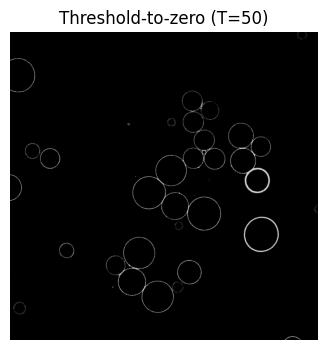

[11:43:49] INFO: Detected 35 raw circles via HoughCircles
[11:43:49] DEBUG: Circle #1: center=(1273,709), r=67, diam=134, mean_intensity=47.8
[11:43:49] DEBUG: Circle #2: center=(260,829), r=64, diam=128, mean_intensity=46.7
[11:43:49] DEBUG: Circle #3: center=(1203,830), r=71, diam=142, mean_intensity=38.1
[11:43:49] DEBUG: Circle #4: center=(1615,976), r=77, diam=154, mean_intensity=53.5
[11:43:49] DEBUG: Circle #5: center=(1334,835), r=73, diam=146, mean_intensity=33.5
[11:43:49] DEBUG: Circle #6: center=(1195,585), r=63, diam=126, mean_intensity=25.6
[11:43:49] DEBUG: Circle #7: center=(1171,1581), r=84, diam=168, mean_intensity=29.0
[11:43:49] DEBUG: Circle #8: center=(700,1532), r=71, diam=142, mean_intensity=28.2
[11:43:49] DEBUG: Circle #9: center=(1631,753), r=72, diam=144, mean_intensity=25.1
[11:43:49] DEBUG: Circle #10: center=(1252,707), r=84, diam=168, mean_intensity=23.5
[11:43:49] DEBUG: Circle #11: center=(1097,1669), r=33, diam=66, mean_intensity=40.0
[11:43:49] DEBUG

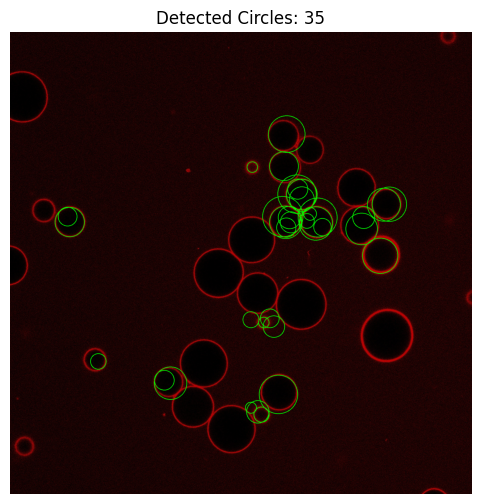

✅ Total circles detected: 35
Diameters (px): [134, 128, 142, 154, 146, 126, 168, 142, 144, 168, 66, 176, 160, 170, 150, 98, 46, 108, 46, 98, 138, 82, 82, 84, 92, 88, 68, 56, 86, 64, 96, 76, 70, 94, 48]
Mean ring intensities: ['47.8', '46.7', '38.1', '53.5', '33.5', '25.6', '29.0', '28.2', '25.1', '23.5', '40.0', '21.7', '24.2', '20.7', '23.3', '23.8', '40.8', '21.1', '38.7', '18.9', '21.2', '23.8', '16.8', '15.2', '17.3', '16.2', '21.7', '20.9', '15.9', '19.5', '15.3', '14.6', '20.9', '21.1', '25.6']
Average diameter: 108.40 px
Average ring intensity: 26.00


In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

# ─── 0. Configure logging ───────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)

# ─── 1. Load image ─────────────────────────────────────────────────────────────
image_path = '/Users/sriujjwalreddyb/TBD/data/OLA-well1-4-Image Export-06_c1.jpg'
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found: {image_path}")

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
if img is None:
    raise ValueError("Failed to load image—check path & permissions")
logging.info(f"Loaded image: {img.shape[1]}×{img.shape[0]} pixels")

# ─── 2. Grayscale ──────────────────────────────────────────────────────────────
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ─── 3. Threshold-to-zero ─────────────────────────────────────────────────────
# All pixels < T become 0; all pixels ≥ T stay at their original gray value.
T = 50  # ← adjust this threshold to taste
_, thresh = cv2.threshold(gray, T, 255, cv2.THRESH_TOZERO)
cv2.imwrite("debug_threshold.jpg", thresh)
logging.info(f"Applied THRESH_TOZERO with T={T}; saved debug_threshold.jpg")

# Optional display:
plt.figure(figsize=(4,4))
plt.imshow(thresh, cmap='gray')
plt.title(f"Threshold-to-zero (T={T})")
plt.axis('off')
plt.show()

# ─── 4. Hough Circle Detection ─────────────────────────────────────────────────
# Tune the parameters (dp, minDist, param1, param2, minRadius, maxRadius)
circles = cv2.HoughCircles(
    thresh,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=20,
    param1=50,
    param2=30,
    minRadius=10,
    maxRadius=90
)

output = img.copy()
diameters = []
ring_intensities = []
circle_count = 0

if circles is not None:
    circles = np.round(circles[0, :]).astype(int)
    logging.info(f"Detected {len(circles)} raw circles via HoughCircles")
    
    for (x, y, r) in circles:
        # draw
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        
        # diameter
        diam = 2 * r
        diameters.append(diam)
        
        # sample intensities around the ring
        angles = np.linspace(0, 2*np.pi, 360, endpoint=False)
        xs = np.clip((x + r * np.cos(angles)).astype(int), 0, gray.shape[1]-1)
        ys = np.clip((y + r * np.sin(angles)).astype(int), 0, gray.shape[0]-1)
        vals = gray[ys, xs]
        ring_intensities.append(vals.mean())
        
        circle_count += 1
        logging.debug(f"Circle #{circle_count}: center=({x},{y}), r={r}, diam={diam}, mean_intensity={vals.mean():.1f}")
else:
    logging.info("No circles found.")

# ─── 5. Show & save final results ───────────────────────────────────────────────
cv2.imwrite("debug_circles.jpg", output)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(output_rgb)
plt.title(f"Detected Circles: {circle_count}")
plt.axis('off')
plt.show()

# ─── 6. Summary ────────────────────────────────────────────────────────────────
print(f"✅ Total circles detected: {circle_count}")
if circle_count:
    print(f"Diameters (px): {diameters}")
    print(f"Mean ring intensities: {[f'{i:.1f}' for i in ring_intensities]}")
    print(f"Average diameter: {np.mean(diameters):.2f} px")
    print(f"Average ring intensity: {np.mean(ring_intensities):.2f}")


[11:46:56] INFO: Contour method: found 0 circles
[11:46:56] INFO: Hough method: found 25 circles


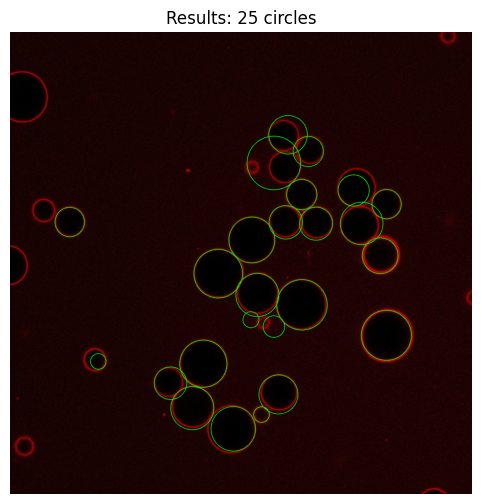

✅ Total detected: 25
Diameters (px): [186, 132, 218, 136, 188, 70, 156, 146, 128, 68, 94, 206, 144, 200, 168, 142, 212, 194, 188, 220, 132, 234, 170, 68, 128]
Mean ring intensities: ['28.9', '27.9', '51.0', '20.2', '34.1', '20.9', '53.6', '32.9', '46.7', '41.7', '21.1', '45.3', '32.9', '55.6', '20.1', '28.2', '45.4', '25.4', '30.7', '40.8', '47.1', '20.4', '28.4', '21.7', '52.1']
Avg diameter: 157.12 px
Avg intensity: 34.91


In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)

def load_image(path, as_gray=True):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Unable to read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if as_gray else img

def threshold_to_zero(gray, thresh):
    """Zero out all pixels below `thresh`."""
    _, th = cv2.threshold(gray, thresh, 255, cv2.THRESH_TOZERO)
    return th

def detect_contour_circles(thresh_img, min_area=200, circularity_thresh=0.6):
    """Find approximate circles via contour circularity."""
    contours, _ = cv2.findContours(
        thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    circs = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        if peri == 0 or area < min_area:
            continue
        circ = 4 * np.pi * area / (peri * peri)
        if circ >= circularity_thresh:
            (x, y), r = cv2.minEnclosingCircle(cnt)
            circs.append((int(x), int(y), int(r)))
    logging.info(f"Contour method: found {len(circs)} circles")
    return circs

def detect_hough_circles(thresh_img, dp=1.2, minDist=20,
                         param1=50, param2=30, minR=10, maxR=90):
    """Refine circle detection via OpenCV Hough Gradient."""
    raw = cv2.HoughCircles(
        thresh_img, cv2.HOUGH_GRADIENT,
        dp=dp, minDist=minDist,
        param1=param1, param2=param2,
        minRadius=minR, maxRadius=maxR
    )
    if raw is None:
        logging.info("Hough method: found 0 circles")
        return []
    circles = np.round(raw[0]).astype(int)
    logging.info(f"Hough method: found {len(circles)} circles")
    return [(x, y, r) for x, y, r in circles]

def sample_ring_intensity(gray, circles):
    """Sample mean intensity around each circle’s circumference."""
    h, w = gray.shape
    means = []
    for x, y, r in circles:
        angles = np.linspace(0, 2*np.pi, 360, endpoint=False)
        xs = np.clip((x + r*np.cos(angles)).astype(int), 0, w-1)
        ys = np.clip((y + r*np.sin(angles)).astype(int), 0, h-1)
        vals = gray[ys, xs]
        means.append(float(vals.mean()))
    return means

def visualize_results(color_img, all_circles, window_title="Results"):
    """Draw circles and show the result."""
    out = color_img.copy()
    for (x, y, r) in all_circles:
        cv2.circle(out, (x, y), r, (0, 255, 0), 2)
    rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.title(f"{window_title}: {len(all_circles)} circles")
    plt.axis('off')
    plt.show()

def main():
    # --- 1. Load & preprocess ---
    gray = load_image('/Users/sriujjwalreddyb/TBD/data/OLA-well1-4-Image Export-06_c1.jpg', as_gray=True)
    color = load_image('/Users/sriujjwalreddyb/TBD/data/OLA-well1-4-Image Export-06_c1.jpg', as_gray=False)
    thresh = threshold_to_zero(gray, thresh=50)
    cv2.imwrite("debug_thresh.png", thresh)
    
    # --- 2. Detect raw via contours ---
    raw_circles = detect_contour_circles(thresh, min_area=100, circularity_thresh=0.7)
    
    # --- 3. Detect refined via Hough ---
    # min/max radius based on image size:
    h, w = gray.shape
    raw_hough = detect_hough_circles(
        thresh,
        dp=1.2,
        minDist=int(min(h,w)*0.05),
        param1=50,
        param2=30,
        minR=int(min(h,w)*0.01),
        maxR=int(min(h,w)*0.06)
    )
    
    # --- 4. Combine & sample intensities ---
    all_circles = raw_circles + raw_hough
    all_circles = list({(x,y,r) for x,y,r in all_circles})  # dedupe
    diameters = [2*r for x,y,r in all_circles]
    intensities = sample_ring_intensity(gray, all_circles)
    
    # --- 5. Visualize ---
    visualize_results(color, all_circles)
    
    # --- 6. Print summary ---
    print(f"✅ Total detected: {len(all_circles)}")
    if diameters:
        print(f"Diameters (px): {diameters}")
        print(f"Mean ring intensities: {[f'{i:.1f}' for i in intensities]}")
        print(f"Avg diameter: {np.mean(diameters):.2f} px")
        print(f"Avg intensity: {np.mean(intensities):.2f}")

if __name__ == "__main__":
    main()



[11:58:04] INFO: Loaded grayscale image: (2016, 2016)
[11:58:04] INFO: Loaded color image: (3, 2016, 2016)
[11:58:04] INFO: Applied THRESH_TOZERO @ 50
[11:58:04] INFO: Contour method: found 0 circles
[11:58:04] INFO: Hough method: found 25 circles
[11:58:04] INFO: Combined total circles: 25


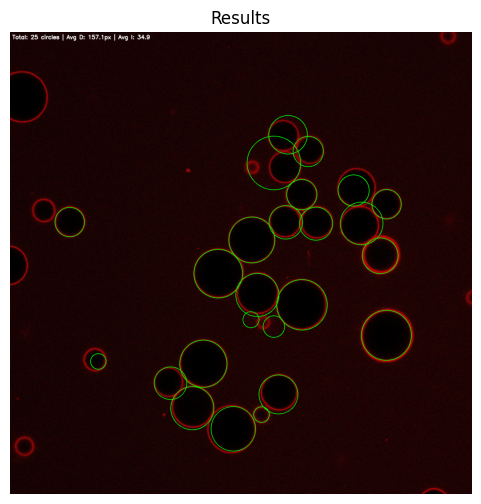

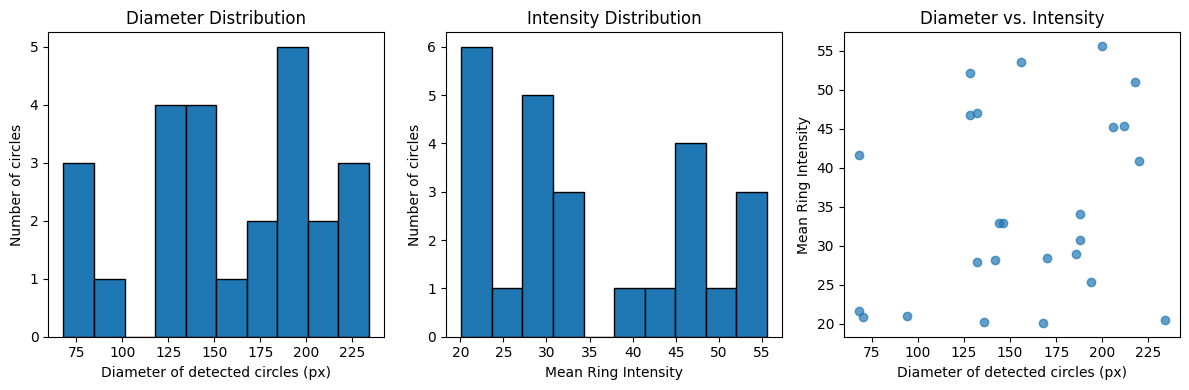

✅ Total circles detected: 25
- Diameters: [186, 132, 218, 136, 188, 70, 156, 146, 128, 68, 94, 206, 144, 200, 168, 142, 212, 194, 188, 220, 132, 234, 170, 68, 128]
- Avg diameter: 157.12 px
- Avg ring intensity: 34.91


In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

# ─── 0. Configure logging ───────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)

def load_image(path, as_gray=True):
    """Load from disk and optionally convert to grayscale."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Unable to read image: {path}")
    if as_gray:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        logging.info(f"Loaded grayscale image: {gray.shape[::-1]}")
        cv2.imwrite("debug_gray.png", gray)
        return gray
    else:
        logging.info(f"Loaded color image: {img.shape[::-1]}")
        return img

def threshold_to_zero(gray, thresh=50):
    """
    Zero out all pixels below `thresh`.
    Adjust `thresh` to suppress more/fewer background pixels.
    """
    _, th = cv2.threshold(gray, thresh, 255, cv2.THRESH_TOZERO)
    logging.info(f"Applied THRESH_TOZERO @ {thresh}")
    cv2.imwrite("debug_thresh.png", th)
    return th

def detect_contour_circles(thresh_img, min_area=100, circularity_thresh=0.7):
    """
    Rough circle detection via contour circularity.
      • min_area: filter out small noise (in px²)
      • circularity_thresh: 0–1, higher → more “perfect” circles
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    circles = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        if peri == 0 or area < min_area:
            continue
        circ = 4 * np.pi * area / (peri * peri)
        if circ >= circularity_thresh:
            (x, y), r = cv2.minEnclosingCircle(cnt)
            circles.append((int(x), int(y), int(r)))
            cv2.circle(out, (int(x), int(y)), int(r), (0,0,255), 1)
    logging.info(f"Contour method: found {len(circles)} circles")
    cv2.imwrite("debug_contours.png", out)
    return circles

def detect_hough_circles(thresh_img, 
                         dp=1.2,           # inverse accumulator resolution
                         minDist=20,       # min center-to-center distance
                         param1=50,        # Canny high threshold
                         param2=30,        # accumulator threshold (lower → more detections)
                         minR=10,          # smallest radius to detect
                         maxR=90):         # largest radius to detect
    """
    Refined detection via OpenCV Hough Gradient.
    Tweak param2 for sensitivity!  
    """
    raw = cv2.HoughCircles(
        thresh_img, cv2.HOUGH_GRADIENT,
        dp=dp, minDist=minDist,
        param1=param1, param2=param2,
        minRadius=minR, maxRadius=maxR
    )
    img_vis = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    if raw is None:
        logging.info("Hough method: found 0 circles")
        cv2.imwrite("debug_hough.png", img_vis)
        return []
    circles = np.round(raw[0]).astype(int)
    for (x, y, r) in circles:
        cv2.circle(img_vis, (x, y), r, (0,255,0), 1)
    logging.info(f"Hough method: found {len(circles)} circles")
    cv2.imwrite("debug_hough.png", img_vis)
    return [(x, y, r) for x, y, r in circles]

def sample_ring_intensity(gray, circles):
    """Sample mean intensity along the circumference of each circle."""
    h, w = gray.shape
    means = []
    for (x, y, r) in circles:
        angles = np.linspace(0, 2*np.pi, 360, endpoint=False)
        xs = np.clip((x + r*np.cos(angles)).astype(int), 0, w-1)
        ys = np.clip((y + r*np.sin(angles)).astype(int), 0, h-1)
        vals = gray[ys, xs]
        means.append(float(vals.mean()))
    return means

def plot_statistics(diameters, intensities):
    """Plot histogram of diameters and ring-intensity scatter/histogram."""
    plt.figure(figsize=(12,4))
    # Diameter distribution
    plt.subplot(1,3,1)
    plt.hist(diameters, bins=10, edgecolor='k')
    plt.xlabel("Diameter of detected circles (px)")  # updated label
    plt.ylabel("Number of circles")                # updated label
    plt.title("Diameter Distribution")
    # Intensity distribution
    plt.subplot(1,3,2)
    plt.hist(intensities, bins=10, edgecolor='k')
    plt.xlabel("Mean Ring Intensity")              # updated label
    plt.ylabel("Number of circles")                # updated label
    plt.title("Intensity Distribution")
    # Scatter plot
    plt.subplot(1,3,3)
    plt.scatter(diameters, intensities, alpha=0.7)
    plt.xlabel("Diameter of detected circles (px)")  # make intuitive
    plt.ylabel("Mean Ring Intensity")                # make intuitive
    plt.title("Diameter vs. Intensity")
    plt.tight_layout()
    plt.savefig("debug_stats.png")
    plt.show()

def visualize_results(color_img, all_circles, diameters, intensities, window_title="Results"):
    """Draw circles, stats overlay, and show the result."""
    out = color_img.copy()
    # Draw circles
    for (x, y, r) in all_circles:
        cv2.circle(out, (x, y), r, (0,255,0), 2)
    # Overlay text
    total = len(all_circles)
    avg_d = np.mean(diameters) if diameters else 0
    avg_i = np.mean(intensities) if intensities else 0
    text = f"Total: {total} circles | Avg D: {avg_d:.1f}px | Avg I: {avg_i:.1f}"
    cv2.putText(out, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255,255,255), 2, cv2.LINE_AA)
    cv2.imwrite("debug_final_overlay.png", out)
    rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.title(f"{window_title}")
    plt.axis('off')
    plt.show()

def main(image_path):
    # 1) Load
    gray = load_image(image_path, as_gray=True)
    color = load_image(image_path, as_gray=False)
    # 2) Threshold
    thresh = threshold_to_zero(gray, thresh=50)  # ← tweak this value
    # 3) Contour-based detection
    raw_circles = detect_contour_circles(thresh,
                                        min_area=100,              # tweak
                                        circularity_thresh=0.7)    # tweak
    # 4) Hough-based detection
    h, w = gray.shape
    hough_circles = detect_hough_circles(thresh,
                                        dp=1.2,
                                        minDist=int(min(h,w)*0.05),
                                        param1=50,
                                        param2=30,
                                        minR=int(min(h,w)*0.01),
                                        maxR=int(min(h,w)*0.06))
    # 5) Combine & dedupe
    all_circles = list({(x,y,r) for (x,y,r) in raw_circles + hough_circles})
    logging.info(f"Combined total circles: {len(all_circles)}")
    # 6) Sample
    diameters = [2*r for (x,y,r) in all_circles]
    intensities = sample_ring_intensity(gray, all_circles)
    # 7) Visualize with stats overlay
    visualize_results(color, all_circles, diameters, intensities)
    # 8) Plot stats
    plot_statistics(diameters, intensities)
    # 9) Summary
    print(f"✅ Total circles detected: {len(all_circles)}")
    if diameters:
        print(f"- Diameters: {diameters}")
        print(f"- Avg diameter: {np.mean(diameters):.2f} px")
        print(f"- Avg ring intensity: {np.mean(intensities):.2f}")

if __name__ == "__main__":
    main("/Users/sriujjwalreddyb/TBD/data/OLA-well1-4-Image Export-06_c1.jpg")
